# GIẢI THUẬT 3: BAYES NGÂY THƠ (NAÏVE BAYES)

## 2.3.3. Bài tập thực hành 1: Xây dựng mô hình Naïve ngây thơ trên tập dữ liệu hành vi của khách hàng

### 1. Giới thiệu về Bộ dữ liệu. 

- Mục đích thu thập dữ liệu
    + Tập dữ liệu này thường được dùng trong các bài toán phân tích hành vi khách hàng (Customer Behaviour Analysis) hoặc mô hình phân loại (Classification) — cụ thể là:
        - Dự đoán khả năng khách hàng mua sản phẩm dựa trên các yếu tố nhân khẩu học như tuổi, giới tính, và thu nhập.
    + Dữ liệu này có thể được mô phỏng từ chiến dịch quảng cáo của một công ty thương mại điện tử hoặc ngân hàng, nơi họ theo dõi ai đã mua hàng sau khi tiếp xúc với quảng cáo.

In [ ]:
# import requirement libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import itertools

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')
plt.style.use('_mpl-gallery')


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [ ]:
# Load tập dữ liệu và kiểm tra 5 dòng đầu tiên
data = pd.read_csv('../data/Customer_Behaviour.csv')
print(f"shape: {data.shape}")
data.head()

shape: (400, 5)


,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


### 2. Tổng quan về Dataset

In [ ]:
df = pd.DataFrame(data)
df

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
...,...,...,...,...,...
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0


- Kích thước: 400 quan sát × 5 biến
- Các cột gồm: 
    + User ID – Mã định danh của khách hàng (duy nhất cho mỗi người)
    + Gender – Giới tính của khách hàng (Male, Female)
    + Age – Tuổi khách hàng
    + EstimatedSalary – Mức thu nhập ước tính (đơn vị: USD/năm hoặc tương đương)
    + Purchased – Biến nhị phân (0 = không mua, 1 = có mua) thể hiện hành vi mua sản phẩm sau khi xem quảng cáo

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


Theo thông tin trên: 
 + Không có giá trị thiếu giữa các cột. 
 + Chúng ta có 4 đặc trưng bao gồm ID người dùng, Giới tính, Tuổi và Lương ước tính.
 + Mục tiêu của chúng ta là Purchased 
 + Chúng ta chỉ có một dữ liệu phân loại đó là Giới tính
 + Cột bỏ đi: User ID chỉ là mã định danh, nó không có ý nghĩa dự đoán.

### 3. Chuẩn bị bộ dữ liệu

In [ ]:
# Check missing value
df.isnull().sum().to_frame('NaN value').T

,User ID,Gender,Age,EstimatedSalary,Purchased
NaN value,0,0,0,0,0


Kiểm tra từng cột để phát hiện lỗi cú pháp hoặc giá trị không hợp lệ

In [ ]:
# kiểm tra số lượng giá trị duy nhất trong mỗi cột
for col in df:
    print(f"{col}: {df[col].nunique()}")

User ID: 400
Gender: 2
Age: 43
EstimatedSalary: 117
Purchased: 2


In [ ]:
# thêm thông tin chi tiết
df.describe(include=[np.number]).T

,count,mean,std,min,25%,50%,75%,max
User ID,400.0,1.569154e+07,71658.321581,15566689.0,15626763.75,15694341.5,15750363.0,15815236.0
Age,400.0,3.765500e+01,10.482877,18.0,29.75,37.0,46.0,60.0
EstimatedSalary,400.0,6.974250e+04,34096.960282,15000.0,43000.00,70000.0,88000.0,150000.0
Purchased,400.0,3.575000e-01,0.479864,0.0,0.00,0.0,1.0,1.0


+ count: Số lượng (đếm) các giá trị không bị thiếu (non-null). Cả 4 cột đều có 400.0, nghĩa là có 400 hàng dữ liệu và không có giá trị nào bị thiếu (NaN).
+ mean: Giá trị trung bình cộng (average) của cột.

 Ví dụ: Tuổi (Age) trung bình là 3.765500e+01 (tức là 37.655 tuổi).

+ Lương (EstimatedSalary) trung bình là 6.974250e+04 (tức là 69,742.5).
+ std: Độ lệch chuẩn (Standard Deviation). Giá trị này đo lường mức độ phân tán của dữ liệu quanh giá trị trung bình.

 std càng lớn (như EstimatedSalary là 34096), dữ liệu càng trải rộng.
 
 std càng nhỏ (như Purchased là 0.479), dữ liệu càng tập trung gần giá trị trung bình.

+ min: Giá trị nhỏ nhất (minimum) trong cột.

 Tuổi nhỏ nhất là 18.0.

 Lương thấp nhất là 15,000.0.

+ 25%: Phân vị thứ 25 (còn gọi là Tứ phân vị thứ nhất - Q1). 25% dữ liệu trong cột có giá trị nhỏ hơn hoặc bằng con số này.

 25% số người có tuổi từ 29.75 trở xuống.

+ 50%: Phân vị thứ 50 (còn gọi là Tứ phân vị thứ hai - Q2 hoặc Median - Trung vị). 50% dữ liệu nhỏ hơn hoặc bằng con số này. Đây là giá trị "ở giữa" của tập dữ liệu.

 Tuổi trung vị là 37.0.

+ 75%: Phân vị thứ 75 (còn gọi là Tứ phân vị thứ ba - Q3). 75% dữ liệu nhỏ hơn hoặc bằng con số này.

 75% số người có tuổi từ 46.0 trở xuống.

+ max: Giá trị lớn nhất (maximum) trong cột.

 Tuổi lớn nhất là 60.0.

 Lương cao nhất là 150,000.0.

In [ ]:
df.describe(include=[object]).T

,count,unique,top,freq
Gender,400,2,Female,204


+ include=[object]: Lệnh này yêu cầu describe() chỉ phân tích các cột có kiểu dữ liệu là object. Đây là kiểu dữ liệu mà Pandas thường dùng để lưu trữ văn bản (ví dụ: "Nam", "Nữ",...).

+ .T: Tương tự như trước, .T (Transpose) được dùng để hoán đổi hàng và cột cho dễ đọc.

Giải thích output:
+ count (400): Cột Gender có 400 mục.
+ unique (2): Có 2 giá trị duy nhất trong cột này (ví dụ: "Female" và "Male").
+ top (Female): Giá trị xuất hiện nhiều nhất là "Female".
+ freq (204): Giá trị "Female" xuất hiện 204 lần.

"Male" sẽ xuất hiện $400 - 204 = 196$ lần.

Theo các bảng trên: 
 + Độ tuổi từ 16 đến 60 tuổi. 
 + Mục tiêu bao gồm 2 lớp 1 và 0.
 + Số lượng nam và nữ trong bộ dữ liệu gần như giống nhau. 
 + Phạm vi tính năng rất khác nhau và cần phải tiêu chuẩn hóa.

Vì Chúng ta không cần cột ID người dùng để xây dựng mô hình dự đoán nên chúng ta bỏ nó

In [ ]:
#  Drop User ID columns
df.drop('User ID', axis=1, inplace=True)
df

,Gender,Age,EstimatedSalary,Purchased
0,Male,19,19000,0
1,Male,35,20000,0
2,Female,26,43000,0
3,Female,27,57000,0
4,Male,19,76000,0
...,...,...,...,...
395,Female,46,41000,1
396,Male,51,23000,1
397,Female,50,20000,1
398,Male,36,33000,0


In [ ]:
# chuyển đổi tính năng phân loại thành số:
# chỉ phân loại dựa trên giới tính
df['Gender'] = df['Gender'].replace(['Male', 'Female'], [0, 1])
df

,Gender,Age,EstimatedSalary,Purchased
0,0,19,19000,0
1,0,35,20000,0
2,1,26,43000,0
3,1,27,57000,0
4,0,19,76000,0
...,...,...,...,...
395,1,46,41000,1
396,0,51,23000,1
397,1,50,20000,1
398,0,36,33000,0


Kiểm tra tập dữ liệu lần cuối

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Gender           400 non-null    int64
 1   Age              400 non-null    int64
 2   EstimatedSalary  400 non-null    int64
 3   Purchased        400 non-null    int64
dtypes: int64(4)
memory usage: 12.6 KB


In [ ]:
df.isna().sum()

Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

### 4. Exploratory Data Analysis (EDA)

- Biểu đồ mật độ (KDE - Kernel Density Estimation) mô tả phân phối của biến “EstimatedSalary” (Mức lương ước tính) theo trạng thái mua hàng (“Đã mua” vs “Chưa mua”)

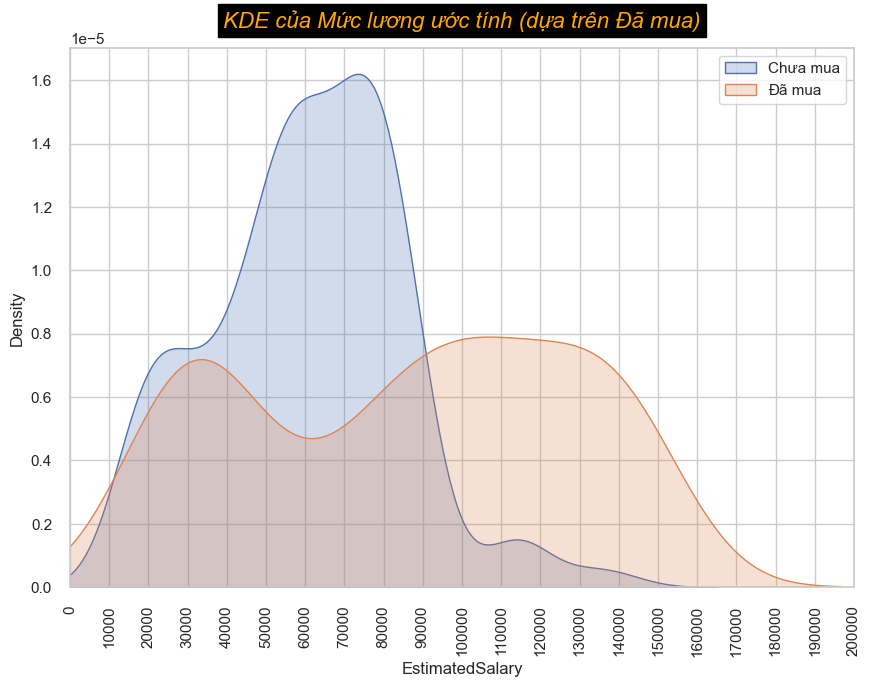

In [ ]:
# kiểm tra phân bổ Mức lương ước tính (dựa trên Đã mua)
font = {'fontsize':16, 'fontstyle':'italic', 'backgroundcolor':'black', 'color':'orange'}

sns.set_theme(style="whitegrid")
sns.kdeplot(df.loc[df['Purchased'] == 0, 'EstimatedSalary'], label='Chưa mua', shade=True)
sns.kdeplot(df.loc[df['Purchased'] == 1, 'EstimatedSalary'], label='Đã mua', shade=True)
plt.title('KDE của Mức lương ước tính (dựa trên Đã mua)', fontdict=font, pad=15)
plt.xticks(np.arange(0,200001,10000), rotation=90)
plt.xlim([0,200001])
plt.legend()
plt.show()

- Mỗi đường (màu xanh & cam) thể hiện phân bố xác suất của mức lương trong từng nhóm khách hàng.
- Biểu đồ KDE giúp ta hiểu mức lương nào xuất hiện nhiều nhất và mức lương nào có xu hướng mua cao hơn.

- Nhóm “Chưa mua” (màu xanh)
    + Phân bố tập trung mạnh ở khoảng 30.000 – 70.000 USD.
    + Đỉnh cao nhất (mode) nằm khoảng 70.000 USD, nghĩa là phần lớn khách hàng chưa mua có mức thu nhập trung bình thấp.
    + Sau khoảng 80.000 USD, mật độ giảm nhanh — cho thấy ít khách hàng có thu nhập cao mà chưa mua.
> Nhận xét: nhóm này có thể là người trẻ tuổi, thu nhập trung bình – thấp, chưa sẵn sàng chi tiêu cho sản phẩm.
- Nhóm “Đã mua” (màu cam)
    + Phân bố lệch về phía thu nhập cao, tập trung trong khoảng 90.000 – 130.000 USD.
    + Có xu hướng mở rộng đến 150.000 USD, nghĩa là có những khách hàng thu nhập rất cao vẫn tiếp tục mua.
    + Mức mật độ thấp hơn nhóm “chưa mua” ở phần thu nhập thấp.
> Nhận xét: nhóm khách hàng có thu nhập cao rõ rệt có khả năng mua hàng cao hơn, chứng tỏ thu nhập là yếu tố quyết định trong hành vi mua.

So sánh hai nhóm
| Đặc điểm    | Chưa mua                       | Đã mua                         |
| ----------- | ------------------------------ | ------------------------------ |
| Phân bố     | Tập trung ở mức thấp (30k–70k) | Tập trung ở mức cao (90k–130k) |
| Đỉnh mật độ | ≈ 50k                          | ≈ 100k                         |
| Xu hướng    | Giảm mạnh khi lương tăng       | Tăng mạnh khi lương tăng       |
| Hành vi     | Tiết kiệm, ít chi tiêu         | Chi tiêu mạnh, có khả năng mua |


- Kết luận:
    + Ngưỡng chuyển đổi hành vi mua xảy ra khoảng 80.000–90.000 USD — từ đây trở đi, tỷ lệ mua hàng tăng rõ rệt.
    + Doanh nghiệp có thể tập trung chiến dịch marketing vào nhóm thu nhập từ 90.000 USD trở lên, vì đây là nhóm “có khả năng mua cao”.
    + Với nhóm thu nhập thấp hơn, có thể cần chiến lược giảm giá, gói trả góp, hoặc gói dùng thử để kích thích hành động mua.

Biểu đồ mật độ (KDE) biểu diễn phân bố độ tuổi của khách hàng theo hành vi mua hàng:

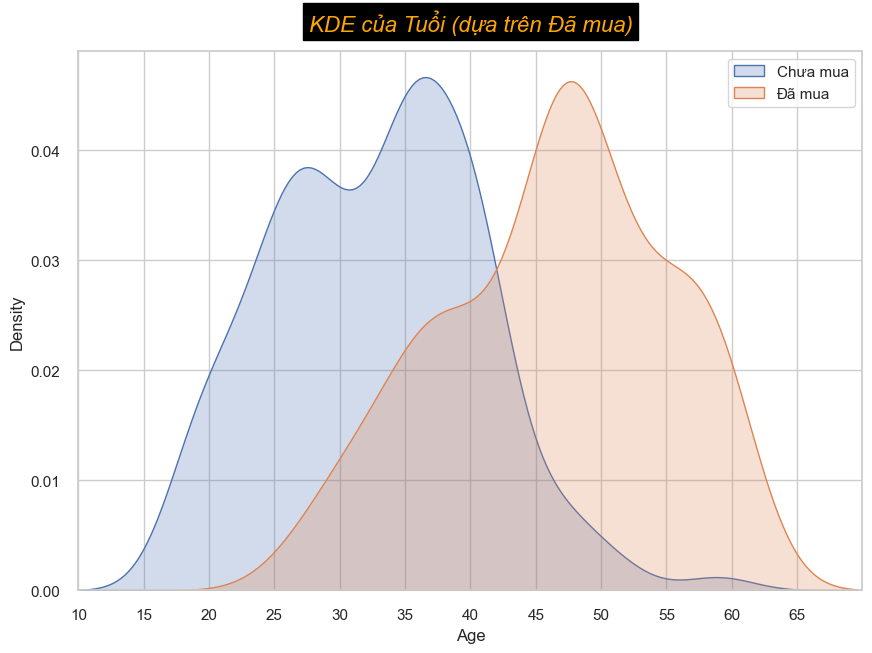

In [ ]:
# kiểm tra phân phối của Đã mua (dựa trên Đã mua)
sns.set_theme(style="whitegrid")
sns.kdeplot(df.loc[df['Purchased'] == 0, 'Age'], label='Chưa mua', shade=True)
sns.kdeplot(df.loc[df['Purchased'] == 1, 'Age'], label='Đã mua', shade=True)
plt.title('KDE của Tuổi (dựa trên Đã mua)', fontdict=font, pad=15)
plt.xticks(np.arange(0,70,5))
plt.xlim([10,70])
plt.legend()
plt.show()

- Nhóm “Chưa mua” (màu xanh):
   + Mật độ cao nhất nằm ở độ tuổi 20–40, đặc biệt đỉnh rõ nhất khoảng 35-38 tuổi.
   + Dựa vào độ tuổi và số lượng mua hàng ta có thể thấy giới trẻ từ khoản 20-33 tỉ lệ mua hàng khá thấp và có xu hướng tăng từ độ tuổi 30.Nhóm này có thể là người trẻ, mới đi làm, ưu tiên tích lũy hơn chi tiêu.
> Người trẻ có xu hướng thận trọng tài chính, hoặc chưa có nhu cầu cấp thiết đối với sản phẩm/dịch vụ mà doanh nghiệp cung cấp.

- Nhóm “Đã mua” (màu cam)
   + Phân bố lệch hẳn sang phía tuổi trung niên (40 trở đi).
   + Đỉnh cao nhất khoảng 45–50 tuổi, cho thấy đây là nhóm mua hàng tích cực nhất.
   + Sau 55–60 tuổi, mật độ bắt đầu giảm — có thể do giảm thu nhập, ít nhu cầu mới, hoặc chuyển sang tiêu dùng tiết kiệm.
> Khách hàng ở độ tuổi trung niên là đối tượng tiềm năng nhất:
   + Họ đã ổn định thu nhập,
   + Có khả năng chi trả,
   + Và ra quyết định nhanh hơn khi thấy giá trị phù hợp.

Nhận xét: 
   - Tuổi là yếu tố ảnh hưởng mạnh đến hành vi mua.
      + Có sự chuyển đổi rõ rệt từ “chưa mua” sang “đã mua” khoảng tuổi 35–40.
   - Nhóm khách hàng mục tiêu tối ưu:
      + Độ tuổi 40–55, vì họ thể hiện tỷ lệ mua cao nhất.
   - Chiến lược marketing nên chia 2 hướng:
      + Tập trung chính: nhóm trung niên (40–55) — chiến dịch nhấn mạnh giá trị, chất lượng, sự tin cậy, tiện ích lâu dài.
      + Mở rộng sang giới trẻ (20–30) — cần điều chỉnh thông điệp và hình ảnh thương hiệu: trẻ trung, hiện đại, trả góp linh hoạt, ưu đãi trải nghiệm.

Mức lương ước tính (EstimatedSalary) theo Giới tính (Gender).

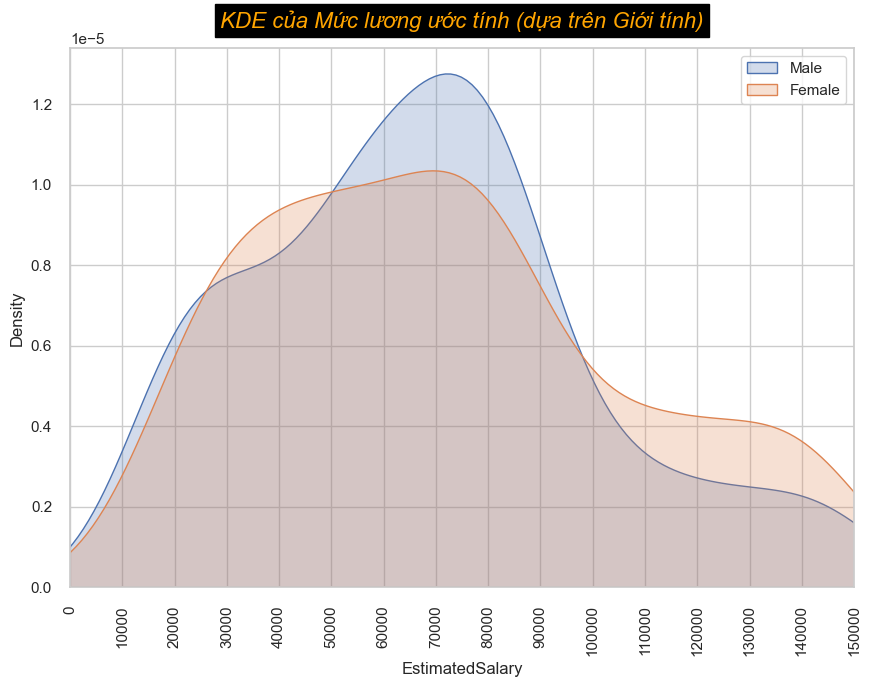

In [ ]:
# kiểm tra phân bổ Mức lương ước tính (dựa trên Giới tính)
sns.set_theme(style="whitegrid")
sns.kdeplot(df.loc[df['Gender'] == 0, 'EstimatedSalary'], label='Male', shade=True)
sns.kdeplot(df.loc[df['Gender'] == 1, 'EstimatedSalary'], label='Female', shade=True)
plt.title('KDE của Mức lương ước tính (dựa trên Giới tính)', fontdict=font, pad=15)
plt.xticks(np.arange(0,150001,10000), rotation=90)
plt.xlim([0,150001])
plt.legend()
plt.show()

Ý nghĩa tổng quát:
 - Biểu đồ hiển thị phân phối mức lương của khách hàng nam và nữ trong dataset.
 - Mỗi đường cong thể hiện mức độ tập trung của thu nhập ở từng khoảng giá trị.
 - Mặc dù biểu đồ chưa trực tiếp thể hiện hành vi mua, nó giúp ta hiểu nền thu nhập giữa hai giới, từ đó liên hệ đến khả năng chi tiêu / mua hàng.

- Nhóm Male (Nam) – màu xanh:
    + Phân bố lương tập trung mạnh quanh 60.000 – 80.000 USD, đỉnh ở khoảng 70.000 USD.
    + Sau 90.000 USD, mật độ giảm nhanh, nhưng vẫn có một phần nhỏ nam giới thu nhập cao (>120.000).
    + Mức phân tán thấp hơn, nghĩa là nam giới trong mẫu dữ liệu có thu nhập tương đối ổn định quanh mức trung bình–khá.
> Nam giới trong dataset có xu hướng thu nhập tập trung, ổn định hơn, dễ rơi vào nhóm “khả năng mua trung bình – cao”.

- Nhóm Female (Nữ) – màu cam:
    + Phân bố khá tương đồng với nam ở phần trung bình (30.000 – 80.000 USD), nhưng:
        - Có mật độ cao hơn ở vùng thu nhập thấp (20.000 – 40.000)
        - Và phân tán rộng hơn ở vùng thu nhập cao (100.000 – 140.000).
    + Điều này cho thấy nhóm nữ trong dataset có độ chênh thu nhập lớn hơn, tức là đa dạng tầng lớp thu nhập.
> Một phần nữ giới thu nhập thấp hơn, nhưng cũng có một nhóm nhỏ thu nhập rất cao, có thể thuộc nhóm khách hàng tiềm năng đặc biệt.

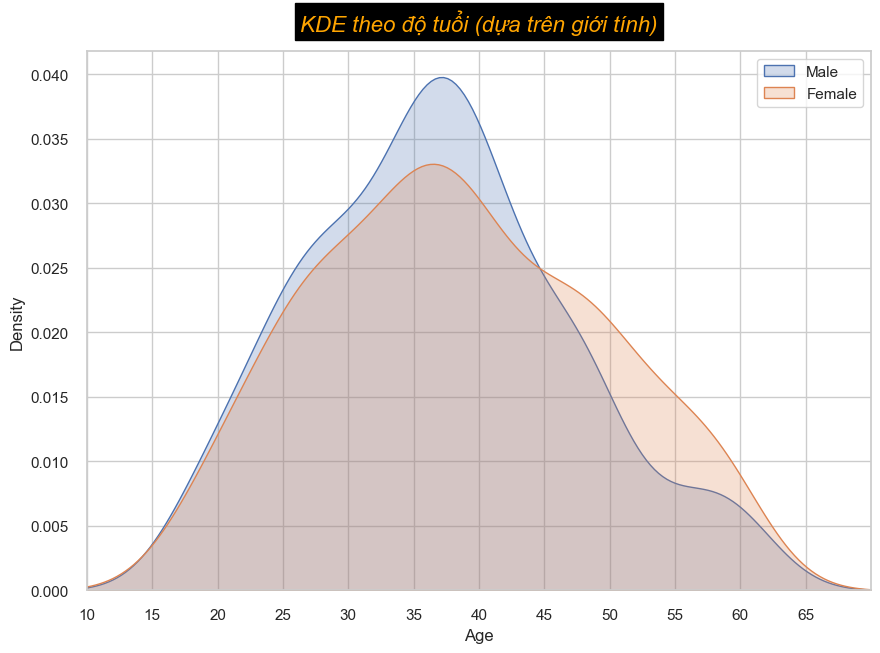

In [ ]:
# kiểm tra phân bổ Tuổi (dựa trên Giới tính)
sns.set_theme(style="whitegrid")
sns.kdeplot(df.loc[df['Gender'] == 0, 'Age'], label='Male', shade=True)
sns.kdeplot(df.loc[df['Gender'] == 1, 'Age'], label='Female', shade=True)
plt.title('KDE theo độ tuổi (dựa trên giới tính)', fontdict=font, pad=15)
plt.xticks(np.arange(0,70,5))
plt.xlim([10,70])
plt.legend()
plt.show()

Mặc dù có một vài khác biệt nhỏ (nam giới tập trung hơn ở độ tuổi ~37, nữ giới trải rộng hơn ở độ tuổi 45-60), nhưng những khác biệt này không đáng kể.

Kết luận: Tương tự như biểu đồ Mức lương (EstimatedSalary) so với Giới tính (Gender) mà bạn đã xem trước đó, biểu đồ này cho thấy Giới tính (Gender) không tạo ra sự khác biệt rõ rệt về phân phối độ tuổi (Age) trong tập dữ liệu này.

Tóm lại, cả nam và nữ trong mẫu dữ liệu này có độ tuổi phân bổ gần như y hệt nhau.

Theo sơ đồ kde trên:

 + Hầu hết những người có thu nhập từ 40000 đến 90000 đều không quyết định mua một sản phẩm nào.

 + Hầu hết những người quyết định mua sản phẩm đều lớn tuổi hơn những người không quyết định mua sản phẩm.

 + Những người trên 43 tuổi thường quan tâm đến việc mua một sản phẩm.

 + Xét về giới tính của mỗi nam hay nữ thì kde gần như giống nhau.

### 4.1. Phân tích đơn biến

Phân bố của biến Purchased trong dataset, mô tả hành vi mua hàng của toàn bộ khách hàng.

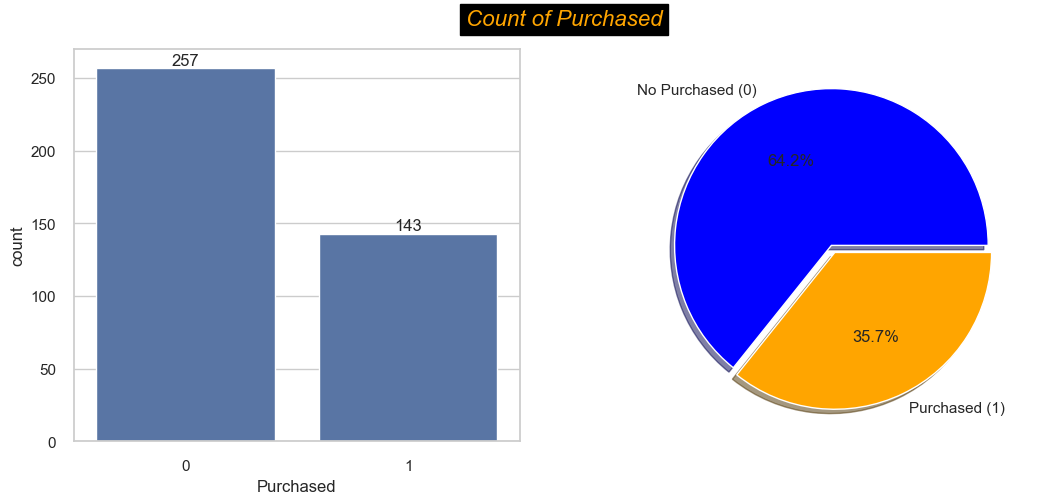

In [ ]:
# số lượng dựa trên Đã mua (countplot)
fig, axes = plt.subplots(1,2,figsize=(10,4))

sns.countplot(data=df, x='Purchased', ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container)

# số lượng dựa trên Đã mua (biểu đồ hình tròn)
slices = df.Purchased.value_counts().values
activities = ['No Purchased (0)', 'Purchased (1)']
axes[1].pie(slices, labels=activities, colors=['blue','orange'], shadow=True, explode=[0,0.05], autopct='%1.1f%%')

plt.suptitle('Count of Purchased', y=1.09, **font)
plt.show()

- Biểu đồ gồm 2 phần:
    + Cột bên trái (Bar chart): số lượng khách hàng đã và chưa mua.
    + Bánh tròn (Pie chart): tỷ lệ phần trăm tương ứng.

- Biến Purchased có 2 giá trị:
    + 0 → Chưa mua hàng
    + 1 → Đã mua hàng

- Nhóm “Chưa mua” (64.3%):
    + Chiếm phần lớn dữ liệu, cho thấy đa số khách hàng chưa ra quyết định mua hàng.
    + Có thể do:
        - Chưa đủ niềm tin / nhận thức về sản phẩm,
        - Hoặc thu nhập, độ tuổi, nhu cầu chưa phù hợp.

> Đây là tệp khách hàng tiềm năng cần được chuyển đổi (target cho chiến dịch remarketing).

- Nhóm “Đã mua” (35.7%)
    + Tuy chiếm tỷ lệ thấp hơn, nhưng đây là tệp khách hàng sinh lời thật sự.
    + Đáng chú ý là tỷ lệ này không quá nhỏ (≈1/3) → chứng tỏ chiến lược hiện tại đã có hiệu quả ở một số phân khúc.
    + Cần phân tích sâu hơn (theo Age, Salary, Gender) để xác định “nhóm vàng” — những khách hàng có đặc điểm dễ mua nhất.


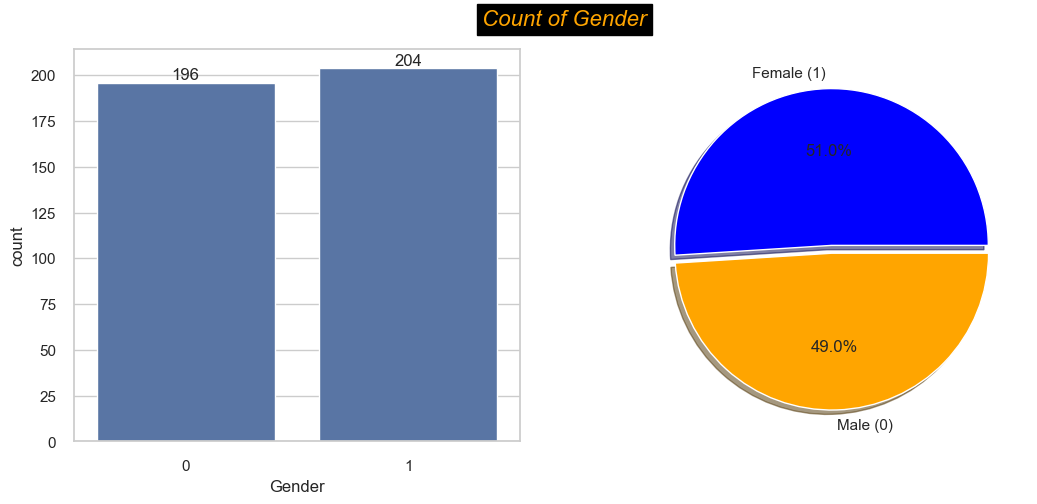

In [ ]:
# số lượng dựa trên giới tính (countplot)
fig, axes = plt.subplots(1,2,figsize=(10,4))

sns.countplot(data=df, x='Gender', ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container)

# số lượng dựa trên Giới tính (biểu đồ hình tròn)
slices = df.Gender.value_counts().values
activities = ['Female (1)', 'Male (0)']
axes[1].pie(slices, labels=activities, colors=['blue','orange'], shadow=True, explode=[0,0.05], autopct='%1.1f%%')

plt.suptitle('Count of Gender', y=1.09, **font)
plt.show()

Theo barplots và tabel trên:

 + Số lượng nam và nữ gần như bằng nhau

 + Số người quyết định mua sản phẩm ít hơn số người không quyết định mua sản phẩm.

### 4.2. Phân tích hai biến

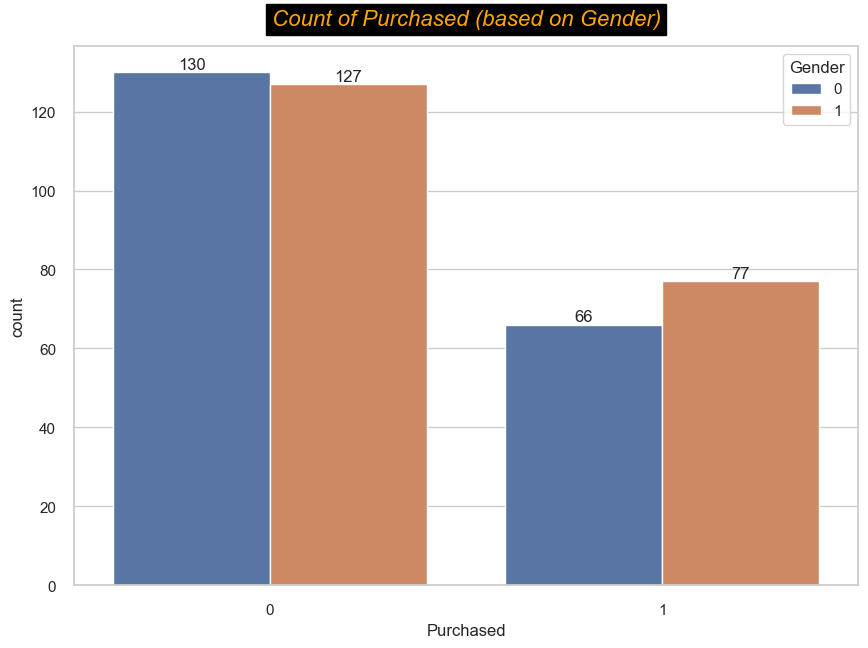

In [ ]:
# số lượng mua dựa trên giới tính
%matplotlib inline
ax = sns.countplot(data=df, x='Purchased', hue='Gender')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count of Purchased (based on Gender)', fontdict=font, pad=15)
plt.show()

Nam không mua nhiều hơn nữ không mua (130>127)

Nam đã mua ít hơn nữ đã mua (66<77)

Khám phá mối quan hệ giữa biến định lượng EstimatedSalary (mức lương ước tính) với hai biến phân loại: Gender và Purchased.

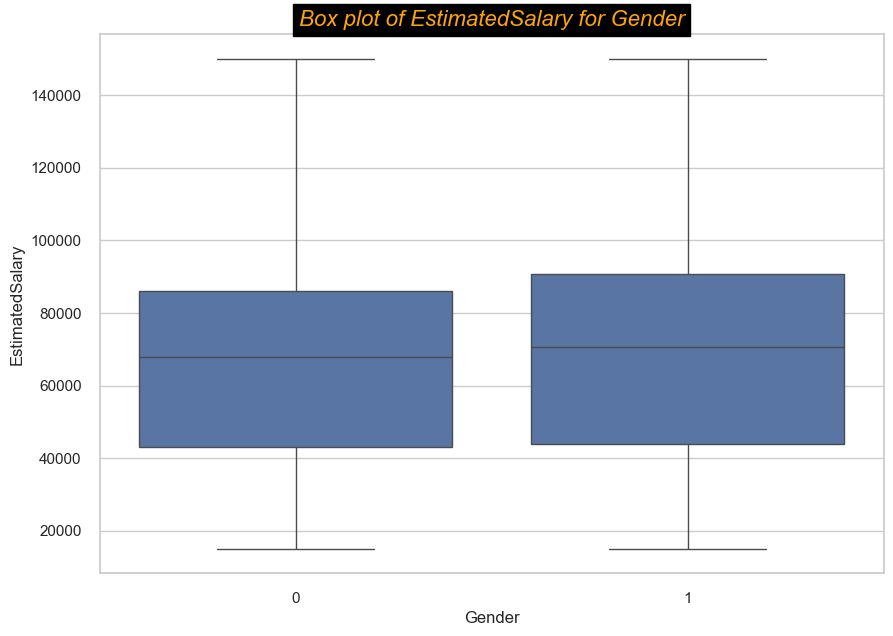

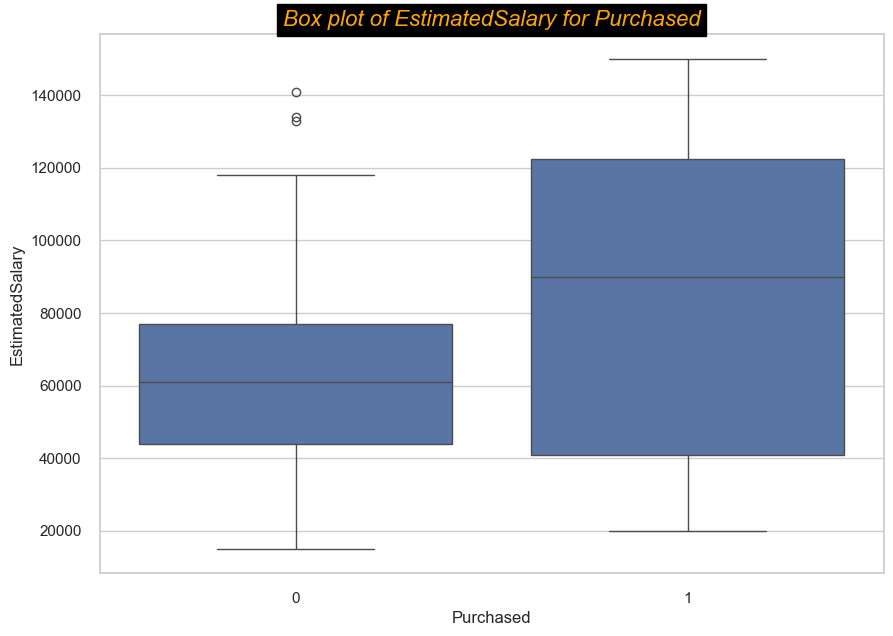

In [ ]:
# vẽ sơ đồ mức lương ước tính cho nam(0) hoặc nữ(1) Giới tính
# vẽ ô biểu đồ Mức lương ước tính cho những người không mua(0) hoặc đã mua(1)
for col in ['Gender', 'Purchased']:
    sns.boxplot(data=df, x=col, y='EstimatedSalary')
    plt.title(f'Box plot of Lương theo {col}', fontdict=font)
    plt.show()

1. Box plot: EstimatedSalary theo Gender
    - Phân bố mức lương của hai giới (0 và 1) khá tương đồng — trung vị (median) gần nhau.
    - Cả hai giới đều có độ phân tán lớn (salary trải rộng từ khoảng 15,000 đến 150,000).
    - Không có dấu hiệu chênh lệch rõ rệt về thu nhập giữa hai nhóm → cho thấy giới tính không ảnh hưởng đáng kể đến mức lương trong dataset này.
    - Biểu đồ cũng không xuất hiện ngoại lệ (outlier) lớn, dữ liệu tương đối cân đối.
> Kết luận: Gender không có ảnh hưởng đáng kể đến biến số EstimatedSalary.

2. Box plot: EstimatedSalary theo Purchased
    - Nhóm Purchased = 1 (đã mua hàng) có mức lương trung vị cao hơn rõ rệt so với nhóm Purchased = 0.
    - Phân bố lương trong nhóm mua hàng cũng rộng hơn (tức là có nhiều người thu nhập cao hơn).
    - Một số ngoại lệ lương cao xuất hiện ở nhóm chưa mua (Purchased = 0), nhưng ít và không ảnh hưởng nhiều đến xu hướng tổng thể.
> Kết luận:Mức lương (EstimatedSalary) có thể ảnh hưởng đáng kể đến quyết định mua hàng. Nói cách khác: “Người có thu nhập cao thường có xu hướng mua hàng nhiều hơn.”

Tổng kết
Theo sơ đồ trên:

 + Trong số những người mua sản phẩm thì nữ nhiều hơn nam, nhưng trong số những người không mua sản phẩm thì nam lại nhiều hơn.

 + Mức lương ước tính trung bình của những người mua sản phẩm cao hơn những người không mua sản phẩm.

 + Mức lương ước tính trung bình của nam và nữ không chênh lệch nhiều.

### 4.3. Phân tích đa biến

Sử dụng biểu đồ phân tán để kiểm tra dữ liệu có tính chất số.

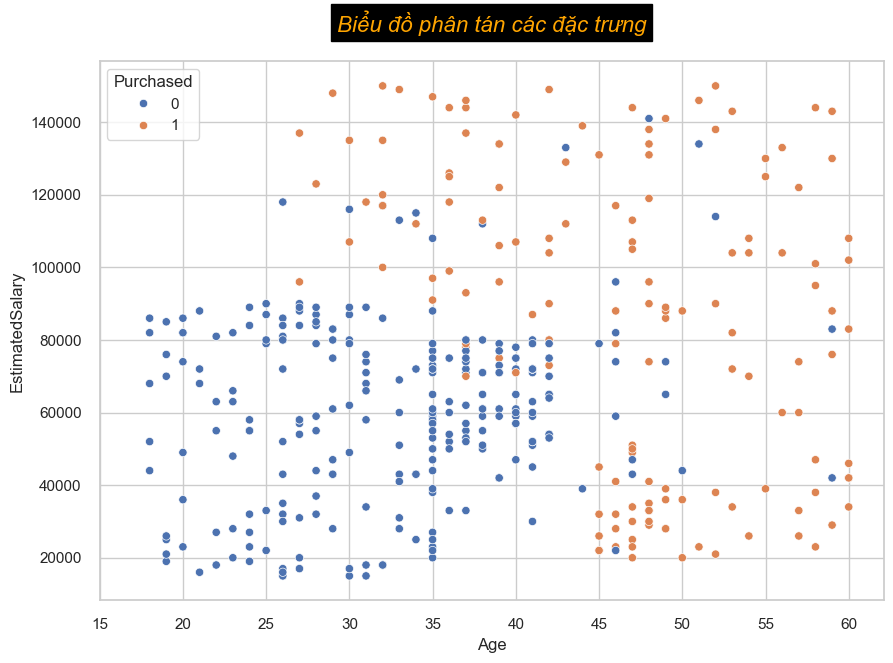

In [ ]:
%matplotlib inline
# check feature correlation
sns.scatterplot(data=df,x='Age', y='EstimatedSalary', hue='Purchased',)
plt.title('Biểu đồ phân tán các đặc trưng', y=1.04, fontdict=font)
plt.xticks(np.arange(15,65,5))
plt.show()

Để nhìn rõ hơn, chúng ta vẽ biểu đồ phân tán 3D

In [ ]:
fig = px.scatter_3d(
        data_frame=df,
        x='Age',
        y='EstimatedSalary',
        z='Gender',
        color='Purchased',
        template='ggplot2',
        opacity=0.6,
        height=700,
        title=f'Phân tán 3d dựa trên Độ tuổi, Mức lương ước tính, Giới tính và Đã mua'
)

pio.show(fig)

In [ ]:
# kiểm tra giá trị trung bình của Mức lương ước tính dựa trên Giới tính và Đã mua
results = pd.pivot_table(data=df, index='Purchased', columns='Gender', values='EstimatedSalary')
results.style.background_gradient(cmap='summer_r')

Gender,0,1
Purchased,,
0,59630.769231,61480.314961
1,83424.242424,88714.285714


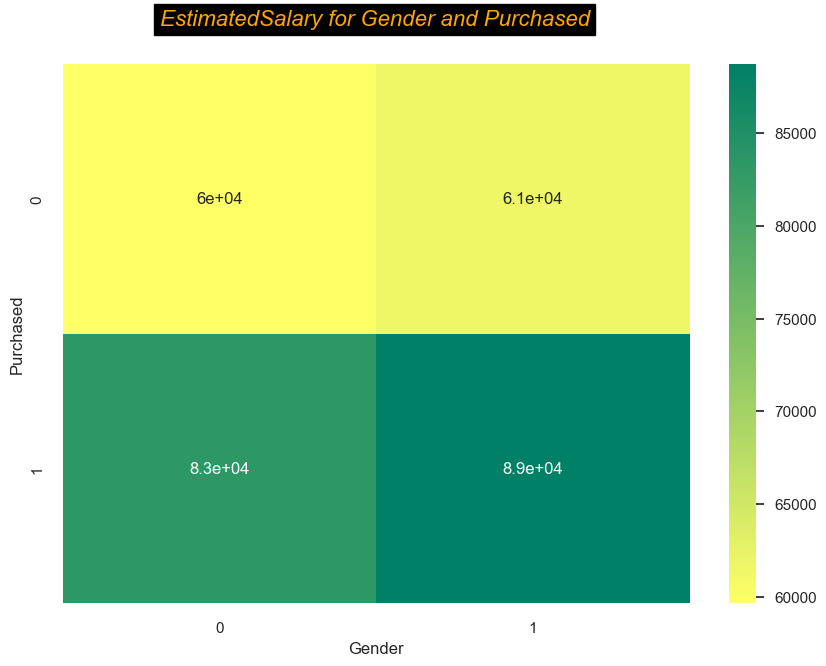

In [ ]:
# hiển thị kết quả trong bản đồ nhiệt
sns.heatmap(results, cmap='summer_r', annot=True)
plt.suptitle('EstimatedSalary for Gender and Purchased', y=1.09, x=0.4, **font)
plt.show()

Bảng này cung cấp hai thông tin chi tiết quan trọng:
 + Yếu tố 'Purchased' là chính: Có một sự chênh lệch rất lớn về lương trung bình giữa nhóm Không mua (hàng 0, ~59-61k) và nhóm Đã mua (hàng 1, ~83-88k). Điều này một lần nữa khẳng định EstimatedSalary là một yếu tố dự đoán mạnh mẽ cho Purchased.
 + Yếu tố 'Gender' là phụ: Trong cả hai trường hợp (Không mua và Đã mua), nhóm Gender = 1 (ví dụ: Nữ) đều có mức lương trung bình cao hơn một chút so với nhóm Gender = 0 (ví dụ: Nam).$61,480 (Nữ) > 59,630 (Nam)$$88,714 (Nữ) > 83,424 (Nam)$

In [ ]:
# kiểm tra độ tuổi trung bình dựa trên giới tính và đã mua
results = pd.pivot_table(data=df, index='Purchased', columns='Gender', values='Age')
results.style.background_gradient(cmap='summer_r')

Gender,0,1
Purchased,,
0,32.484615,33.110236
1,45.500000,47.155844


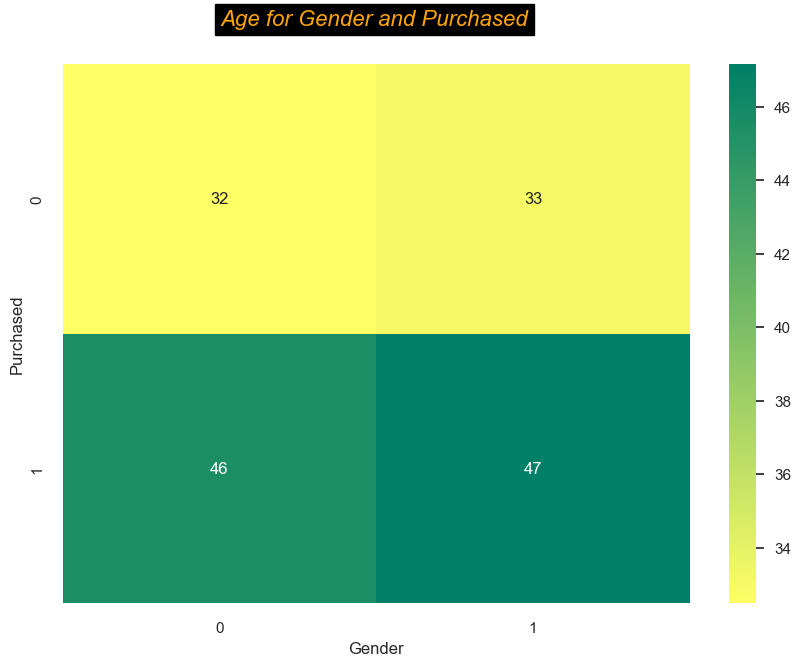

In [ ]:
# hiển thị kết quả trong bản đồ nhiệt
sns.heatmap(results, cmap='summer_r', annot=True)
plt.suptitle('Age for Gender and Purchased', y=1.09, x=0.4, **font)
plt.show()

Bảng này cung cấp thông tin chi tiết rất rõ ràng, tương tự như bảng phân tích Lương:
 + Yếu tố 'Purchased' là chính (Rất mạnh): Có một sự chênh lệch tuổi tác rất lớn giữa hai nhóm. Nhóm Không mua (hàng 0) có tuổi trung bình chỉ khoảng ~32-33 tuổi, trong khi nhóm Đã mua (hàng 1) có tuổi trung bình cao hơn nhiều, khoảng ~45-47 tuổi. Điều này một lần nữa khẳng định Age là yếu tố dự đoán cực kỳ quan trọng.
 + Yếu tố 'Gender' là phụ: Tương tự như phân tích lương, trong cả hai trường hợp (Không mua và Đã mua), nhóm Gender = 1 đều có độ tuổi trung bình cao hơn một chút so với nhóm Gender = 0.$33.1 (Gender 1) > 32.4 (Gender 0)$$47.1 (Gender 1) > 45.5 (Gender 0)$

Theo sơ đồ trên:

 + Những người có độ tuổi trẻ và mức lương ước tính thấp thường không mua sản phẩm.

 + Những người có Mức lương ước tính trên 100.000, bất kể Tuổi tác, thường mua sản phẩm.

 + Những người trên 45 tuổi, bất kể mức lương ước tính của họ, đều có nhiều khả năng mua sản phẩm hơn.

Những lô này cũng xác nhận kết quả trước đó

### 5. Mô hình

In [ ]:
# Tập dữ liệu sử dụng để lập mô hình
df

,Gender,Age,EstimatedSalary,Purchased
0,0,19,19000,0
1,0,35,20000,0
2,1,26,43000,0
3,1,27,57000,0
4,0,19,76000,0
...,...,...,...,...
395,1,46,41000,1
396,0,51,23000,1
397,1,50,20000,1
398,0,36,33000,0


Như bạn có thể thấy, cả hai loại dữ liệu rời rạc và liên tục đều có thể được nhìn thấy trong tập dữ liệu, vì vậy trong số các loại Naive Bayes, chúng ta sử dụng Multinomial Naive Bayes. Vì phạm vi tính năng rất khác nhau, như đã đề cập trước đó, nên chúng cần được chuẩn hóa trước tiên.

In [ ]:
# Chuẩn hóa mức lương ước tính và độ tuổi với StandardScaler
df2 = df.copy()
scaler = MinMaxScaler(feature_range=(18,60)).fit(df[['EstimatedSalary']])
df2['EstimatedSalary'] = scaler.transform(df2['EstimatedSalary'].values.reshape(-1,1))
df2

,Gender,Age,EstimatedSalary,Purchased
0,0,19,19.244444,0
1,0,35,19.555556,0
2,1,26,26.711111,0
3,1,27,31.066667,0
4,0,19,36.977778,0
...,...,...,...,...
395,1,46,26.088889,1
396,0,51,20.488889,1
397,1,50,19.555556,1
398,0,36,23.600000,0


In [ ]:
# xác đinhj x (đặc trưng) and y (target)
x = np.asanyarray(df2.drop('Purchased', axis=1))
y = df2.Purchased.values.reshape(-1,1)

In [ ]:
FPR1 = []
TPR1 = []
FPR0 = []
TPR0 = []
ACC_test = []
ACC_train = []
Recall = []
Precision = []
F1 = []

def plot_confusion_matrix2(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
        cm(array): confusion matrix
        classes(dictionary): classes in our target
    """
    plt.figure(figsize=(10,7))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt ='d'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

# --------------------------------------------------------------------------------------

def Perform_cross_val(model, k, x, y, scoring):
    """
    perform cross validation
        model: logistic model
        k(scaler): the value for n_splits in KFold()
        x(DataFrame or array):  x_train
        y(DataFrame or array): y_train
        scoring(string): an approach for evaluation in cross validation
    """

    kf = KFold(n_splits=k)
    cv_results = cross_val_score(model, x, y, cv=kf, scoring=scoring)
    cv_mean = np.mean(cv_results)
    print('-'*20, f"CV for k={k}, scoring={scoring}", '-'*20)
    print(f"CV mean: {cv_mean}")
    print(f"CV results: {cv_results}\n")

# --------------------------------------------------------------------------------------

def find_fold_index(k, x):
    """
    Find fold index in kfold
        k(scaler): the value used for n_splits in KFold()
        x(DataFrame or array): x_train
    """

    my_fold_index = []
    j=1
    for _ , test in KFold(k).split(x):

        my_fold_index = []
        for i in test:
            my_fold_index.append(i)
        print(f"fold {j}: [{my_fold_index[0]},{my_fold_index[-1]}]")
        print(20*'-')
        j += 1

# --------------------------------------------------------------------------------------

def plot_results(FPR0, TPR0, FPR1, TPR1, ACC_test, ACC_train, Recall, Precision, F1):
    """
    draw ROC curve and plot of Recall, precision, f1 score etc.
        FPR0(list): list of False Positive Rate for class 0
        TPR0(list): list of True Positive Rate for class 0
        FPR1(list): list of Flase Positive Rate for class 1
        TPR1(list): list of True Positive Rate for class 1
        ACC(list): list of accuracy of models
        Recall(list): list of recall score of models
        Precision(list): list of Precision score of models
        F1(list): list of F1 score of models 
    """
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    # plot model evaluation
    ax[0].set_title('Kết quả đánh giá mô hình', fontdict=font, y=1.02)
    sns.lineplot(data=pd.DataFrame({'accoracy': ACC_test, 'Recall': Recall,
                                    'Precision': Precision, 'F1 score': F1}), 
                                    markers=True, ax=ax[0])
    ax[0].set_xlabel('M')
    ax[0].set_ylabel('Evaluation')
    ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
          fancybox=True, shadow=True)

    # plot model evaluation
    ax[1].set_title('Kết quả huấn luyện và kiểm tra', fontdict=font, y=1.02)
    sns.lineplot(data=pd.DataFrame({'test accuracy': ACC_test, 'train accuracy': ACC_train}), 
                                    markers=True, ax=ax[1])
    ax[1].set_xlabel('M')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
          fancybox=True, shadow=True)
    plt.show()

    # plot ROC curve for class 1
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    i=1
    ax[0].set_title('ROC Curve of Class 1', fontdict=font, y=1.02)
    for fpr , tpr in zip(FPR1, TPR1):
        ax[0].plot(fpr, tpr, label=f"ROC curve of model{i} (AUC = {round(metrics.auc(fpr, tpr),3)})")
        i += 1
        ax[0].set_xlabel('FPR')
        ax[0].set_ylabel('TPR')
    ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
          fancybox=True, shadow=True)
        
    # plot ROC curve for class zero
    i=1
    ax[1].set_title('ROC Curve of Class 0', fontdict=font, y=1.02)
    for fpr , tpr in zip(FPR0, TPR0):
        ax[1].plot(fpr, tpr, '--', label=f"ROC curve of model{i} (AUC = {round(metrics.auc(fpr, tpr),3)})")
        i += 1
        ax[1].set_xlabel('FPR')
        ax[1].set_ylabel('TPR')
    ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
        fancybox=True, shadow=True)
    
    plt.show()

# --------------------------------------------------------------------------------------


def modeling(x, y, test_size, classes, is_add=1 ):

    # split data to train and test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=0)
    print(20*'-', 'Shape', 20*'-')
    print(f"x_train: {x_train.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"x_test: {x_test.shape}")
    print(f"y_test: {y_test.shape}")
    


    # define model and fit model
    clf = MultinomialNB()
    clf.fit(x_train, y_train.ravel())

    # prediction and results
    y_pred_train = clf.predict(x_train)
    y_pred_test = clf.predict(x_test)
    y_proba_train = clf.predict_proba(x_train)
    y_proba_test = clf.predict_proba(x_test)

    cm = metrics.confusion_matrix(y_test, y_pred_test)
    fpr1, tpr1, _ = metrics.roc_curve(y_test, y_proba_test[:,1])
    fpr0, tpr0, _ = metrics.roc_curve(y_test, y_proba_test[:,0])
    acc_test = metrics.accuracy_score(y_test, y_pred_test)
    acc_train = metrics.accuracy_score(y_train, y_pred_train)
    rec = metrics.recall_score(y_test, y_pred_test)
    pre = metrics.precision_score(y_test, y_pred_test)
    f1 = metrics.f1_score(y_test, y_pred_test)

    # append results
    if is_add == 1:
        FPR0.append(fpr0)
        TPR0.append(tpr0)
        FPR1.append(fpr1)
        TPR1.append(tpr1)
        ACC_test.append(acc_test)
        ACC_train.append(acc_train)
        Recall.append(rec)
        Precision.append(pre)
        F1.append(f1)

    plot_results(FPR0, TPR0, FPR1, TPR1, ACC_test, ACC_train, Recall, Precision, F1)

    # Evaluation model
    print('-'*20 , 'Ma trận nhầm lẫn', '-'*20)
    print(cm)
    plot_confusion_matrix2(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
    # or use plot_confusion_matrix from sklearn.metrics
    print('-'*20 , 'Classification Report', '-'*20)
    print(metrics.classification_report(y_test, y_pred_test, target_names=classes), '\n')
    print(f"Jaccard Score: {metrics.jaccard_score(y_test, y_pred_test)}", '\n')

    # print other result about predicted data
    return clf, acc_test, acc_train

Đoạn code trên thực hiện:
1. Chia dữ liệu: Tách bộ dữ liệu đầu vào (x, y) thành các tập huấn luyện (train) và kiểm tra (test).
2. Huấn luyện: Khởi tạo và huấn luyện mô hình MultinomialNB trên tập x_train, y_train.
3. Dự đoán: Sử dụng mô hình đã huấn luyện để dự đoán trên cả tập train và test.
4. Tính toán chỉ số: Tính toán một loạt các chỉ số đánh giá hiệu suất mô hình trên tập test, bao gồm:
 + Ma trận nhầm lẫn (Confusion Matrix)
 + Độ chính xác (Accuracy)
 + Độ nhạy (Recall)
 + Độ đặc hiệu (Precision)
 + Chỉ số F1 (F1 Score)
 + Dữ liệu cho đường cong ROC (FPR, TPR) cho cả hai lớp (0 và 1).
5. Lưu trữ kết quả: Thêm các chỉ số vừa tính được vào các danh sách toàn cục (như ACC_test, FPR1, Recall, v.v.) để theo dõi qua nhiều lần chạy.
6. Trực quan hóa: Gọi hàm plot_results để vẽ tất cả các biểu đồ và hàm plot_confusion_matrix2 để vẽ ma trận nhầm lẫn.
7. In kết quả: In ra báo cáo phân loại (Classification Report) và điểm Jaccard.

Hàm trực quan hóa và thu thập:

+ Các danh sách toàn cục (FPR1, TPR1, ACC_test...): Đây là các "bộ lưu trữ" dùng để thu thập kết quả (accuracy, recall, v.v.) từ nhiều lần chạy hàm modeling. Điều này hữu ích khi bạn muốn so sánh hiệu suất của các mô hình khác nhau (ví dụ: với các tham số khác nhau).
+ plot_results: Hàm này lấy tất cả dữ liệu đã thu thập trong các danh sách toàn cục và vẽ 4 biểu đồ:

    Biểu đồ đường so sánh accuracy, Recall, Precision, F1 score.

    Biểu đồ đường so sánh test accuracy và train accuracy (để kiểm tra overfitting).

    Biểu đồ đường cong ROC (và AUC) cho Lớp 1.

    Biểu đồ đường cong ROC (và AUC) cho Lớp 0.
    
+ plot_confusion_matrix2: Một hàm tiện ích tùy chỉnh để vẽ ma trận nhầm lẫn (confusion matrix) một cách rõ ràng, đẹp mắt bằng matplotlib

+ Perform_cross_val: Một hàm riêng biệt để thực hiện đánh giá chéo K-fold (K-Fold Cross-Validation). Hàm này giúp đánh giá độ ổn định của mô hình một cách tổng quát hơn là chỉ dùng một lần chia train/test.

+ find_fold_index: Một hàm trợ giúp để in ra chỉ mục (index) bắt đầu và kết thúc của từng "fold" (lần lặp) trong K-fold.

-------------------- Shape --------------------
x_train: (320, 3)
y_train: (320, 1)
x_test: (80, 3)
y_test: (80, 1)


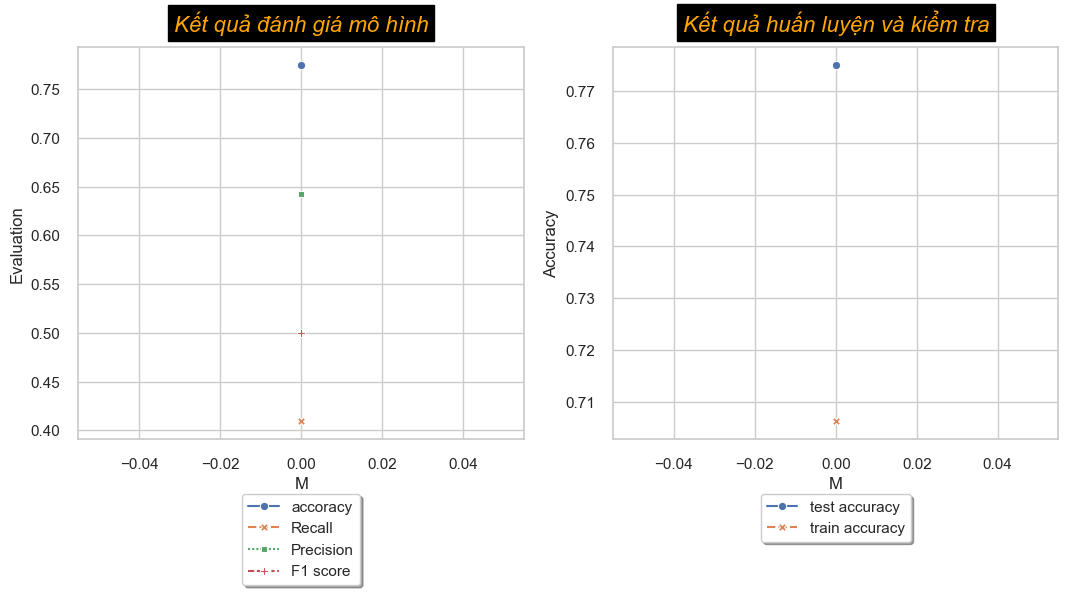

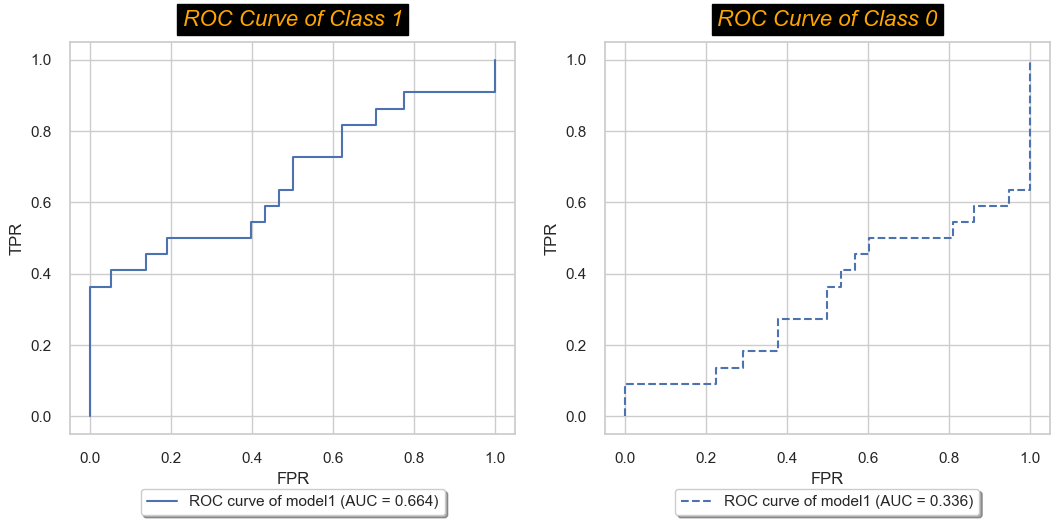

-------------------- Ma trận nhầm lẫn --------------------
[[53  5]
 [13  9]]


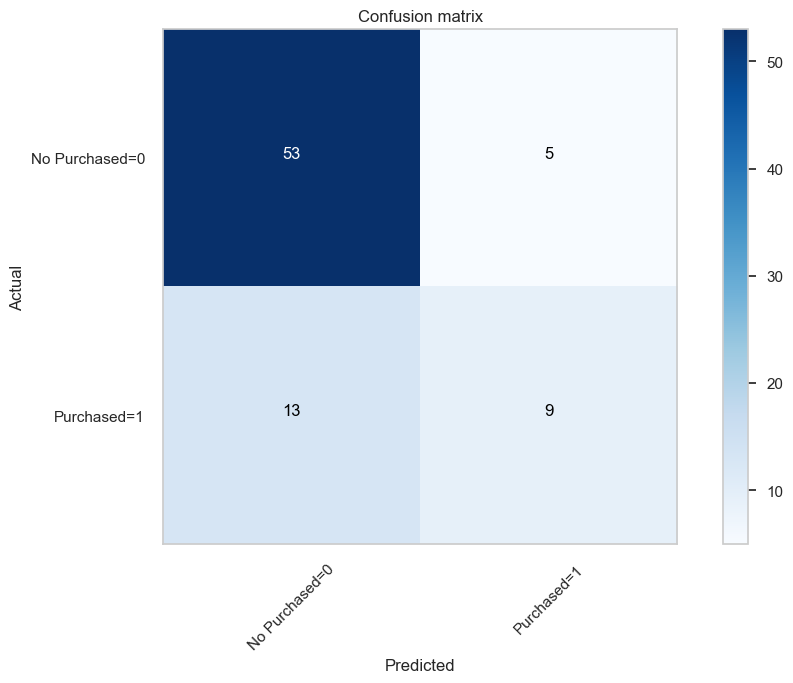

-------------------- Classification Report --------------------
                precision    recall  f1-score   support

No Purchased=0       0.80      0.91      0.85        58
   Purchased=1       0.64      0.41      0.50        22

      accuracy                           0.78        80
     macro avg       0.72      0.66      0.68        80
  weighted avg       0.76      0.78      0.76        80
 

Jaccard Score: 0.3333333333333333 



In [ ]:
# tạo mô hình đầu tiên
clf1, acc_test1, acc_train1 = modeling(x, y, 0.2, ['No Purchased=0', 'Purchased=1'])

1. Tổng quan (Accuracy)Accuracy (Độ chính xác tổng thể): 0.78 (78%)
 + Đây là chỉ số đơn giản nhất. Nó cho biết mô hình đã dự đoán đúng 78% trong tổng số 80 mẫu của tập kiểm tra (test set).
 + Tuy nhiên, chỉ số này có thể gây hiểu nhầm khi dữ liệu bị mất cân bằng (lớp 0 có 58 mẫu, lớp 1 chỉ có 22 mẫu).
2. Phân tích theo từng lớp
 + Lớp No Purchased=0 (Không mua):

    Support (Số lượng mẫu): 58. Có 58 người thực sự "Không mua" trong tập dữ liệu kiểm tra.

    Precision (Độ chính xác dự đoán): 0.80. Khi mô hình dự đoán một người là "Không mua", nó đúng 80% số lần.

    Recall (Độ nhạy - Tỷ lệ phát hiện): 0.91. Trong tất cả 58 người thực sự "Không mua", mô hình đã phát hiện đúng 91% (tức là 53 người). Đây là một kết quả rất tốt.

    F1-Score: 0.85. Đây là trung bình điều hòa (harmonic mean) của Precision và Recall. Điểm số 0.85 là cao, cho thấy hiệu suất cân bằng và tốt cho lớp này.

 + Lớp Purchased=1 (Đã mua):

   Support (Số lượng mẫu): 22. Có 22 người thực sự "Đã mua" trong tập dữ liệu kiểm tra.
   
   Precision (Độ chính xác dự đoán): 0.64. Khi mô hình dự đoán một người là "Đã mua", nó chỉ đúng 64% số lần. (36% còn lại là dự đoán sai - False Positives).
   
   Recall (Độ nhạy - Tỷ lệ phát hiện): 0.41. Đây là vấn đề lớn nhất. Trong tất cả 22 người thực sự "Đã mua", mô hình chỉ phát hiện đúng được 41% (tức là khoảng 9 người).Nó đã bỏ lót 59% số người "Đã mua" (xếp nhầm họ vào lớp "Không mua" - False Negatives).
   
   F1-Score: 0.50. Điểm F1 thấp (chỉ 0.50) phản ánh rằng mô hình hoạt động không hiệu quả cho lớp này, do cả Precision và Recall đều không cao.

3. Các chỉ số trung bình
 + Macro Avg (Trung bình cộng):Tính trung bình (0.80 + 0.64) / 2 = 0.72 cho precision.Nó coi cả hai lớp là quan trọng như nhau, bất kể số lượng mẫu.
 + Weighted Avg (Trung bình theo trọng số):Tính trung bình dựa trên số lượng mẫu (support) của mỗi lớp.Vì lớp "Không mua" (58 mẫu) có nhiều hơn lớp "Đã mua" (22 mẫu), nên kết quả trung bình (ví dụ: F1-score là 0.76) bị kéo về phía hiệu suất tốt của lớp 0.
4. Jaccard ScoreJaccard Score: 0.333...
   Đây là một chỉ số khác để đo lường hiệu suất, được tính bằng $TP / (TP + FP + FN)$.

   Nó đo lường mức độ tương đồng giữa tập dự đoán và tập nhãn thực tế cho lớp dương tính (lớp 1).
   
   Giá trị 0.33 là khá thấp (tối đa là 1), một lần nữa khẳng định rằng mô hình dự đoán lớp "Purchased=1" không tốt.

### 6. Cải tiến mô hình

Đầu tiên hãy kiểm tra một số test_size để cải thiện mô hình

-------------------- Shape --------------------
x_train: (280, 3)
y_train: (280, 1)
x_test: (120, 3)
y_test: (120, 1)


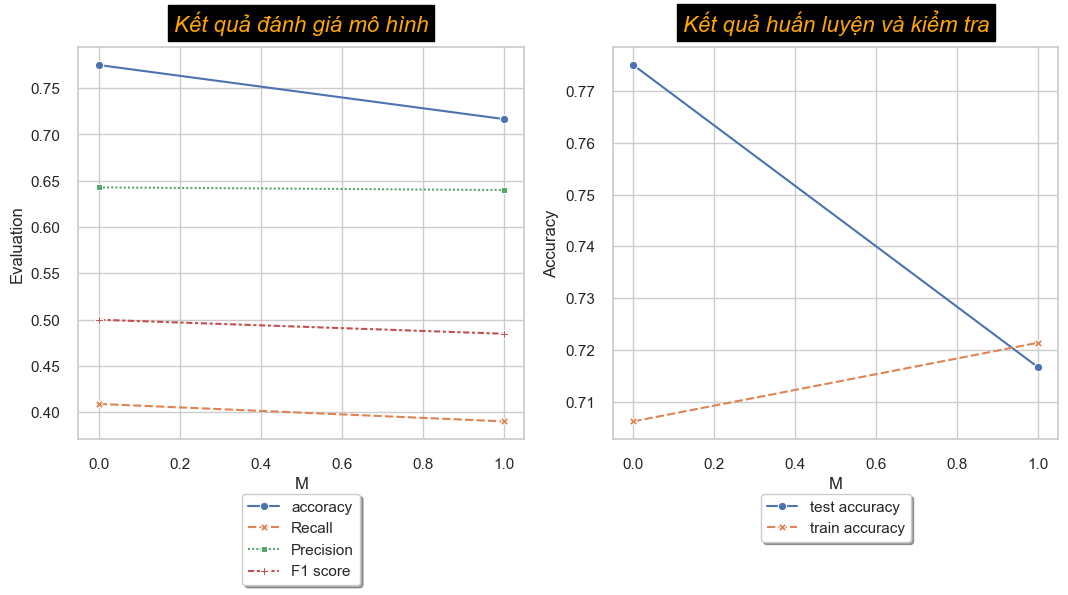

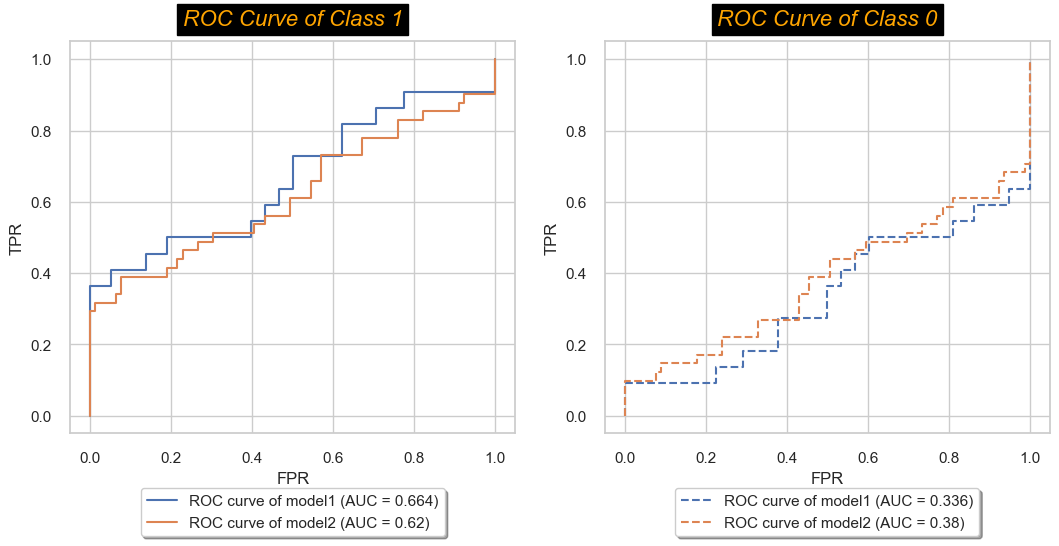

-------------------- Ma trận nhầm lẫn --------------------
[[70  9]
 [25 16]]


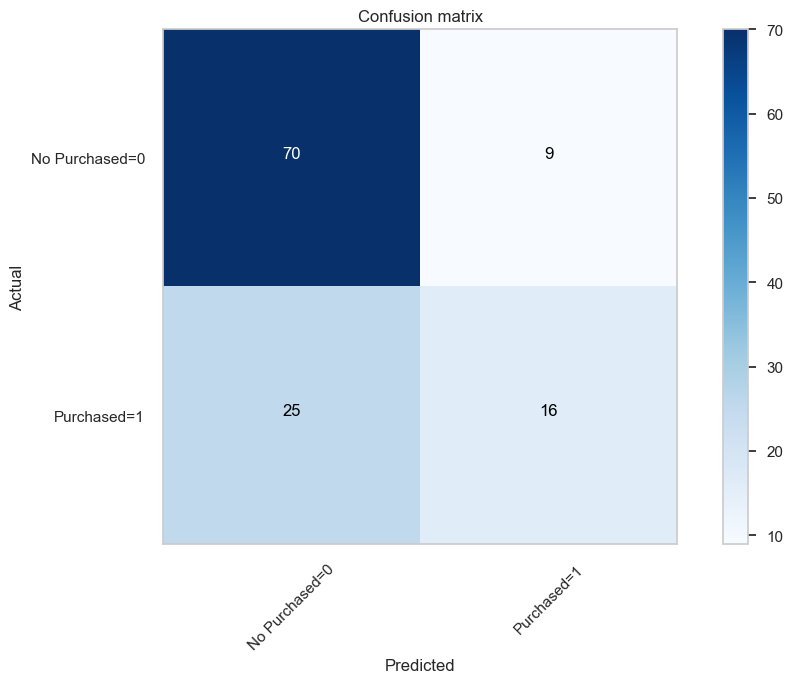

-------------------- Classification Report --------------------
                precision    recall  f1-score   support

No Purchased=0       0.74      0.89      0.80        79
   Purchased=1       0.64      0.39      0.48        41

      accuracy                           0.72       120
     macro avg       0.69      0.64      0.64       120
  weighted avg       0.70      0.72      0.70       120
 

Jaccard Score: 0.32 



In [ ]:
# test test_size= 0.3
clf2, acc_test2, acc_train2 = modeling(x, y, 0.3, ['No Purchased=0', 'Purchased=1'])

-------------------- Shape --------------------
x_train: (340, 3)
y_train: (340, 1)
x_test: (60, 3)
y_test: (60, 1)


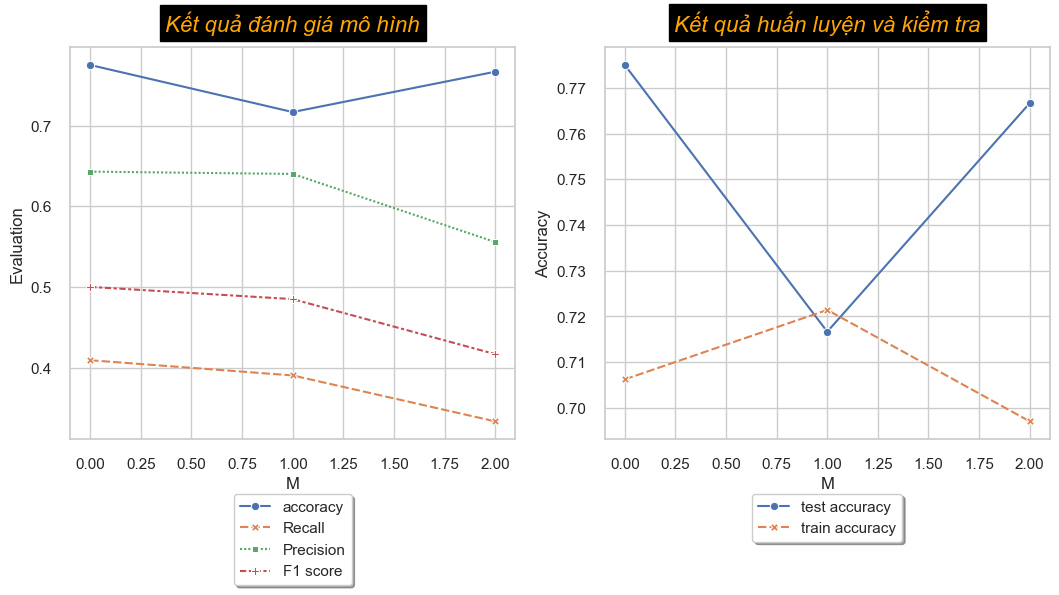

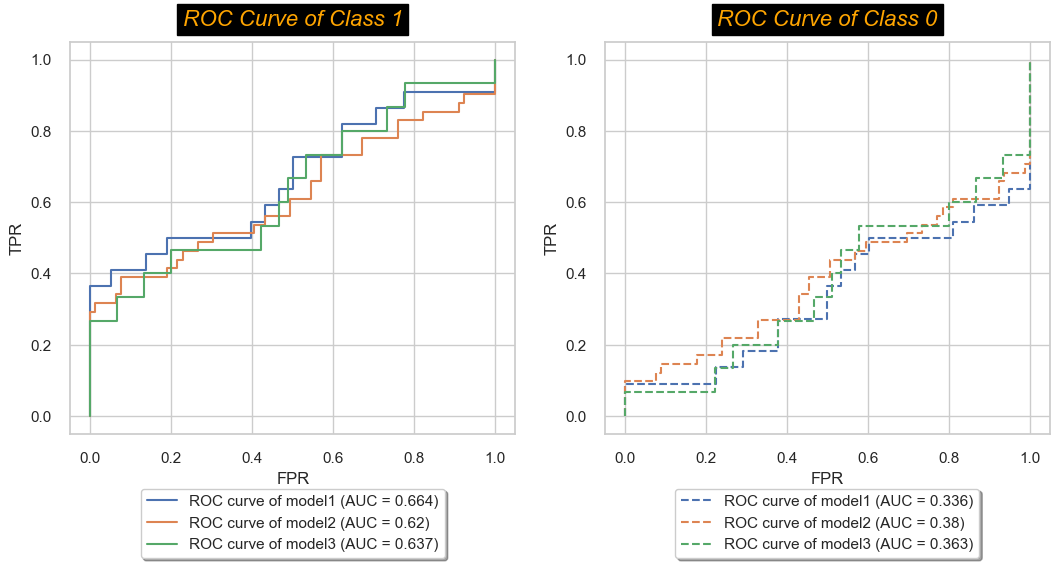

-------------------- Ma trận nhầm lẫn --------------------
[[41  4]
 [10  5]]


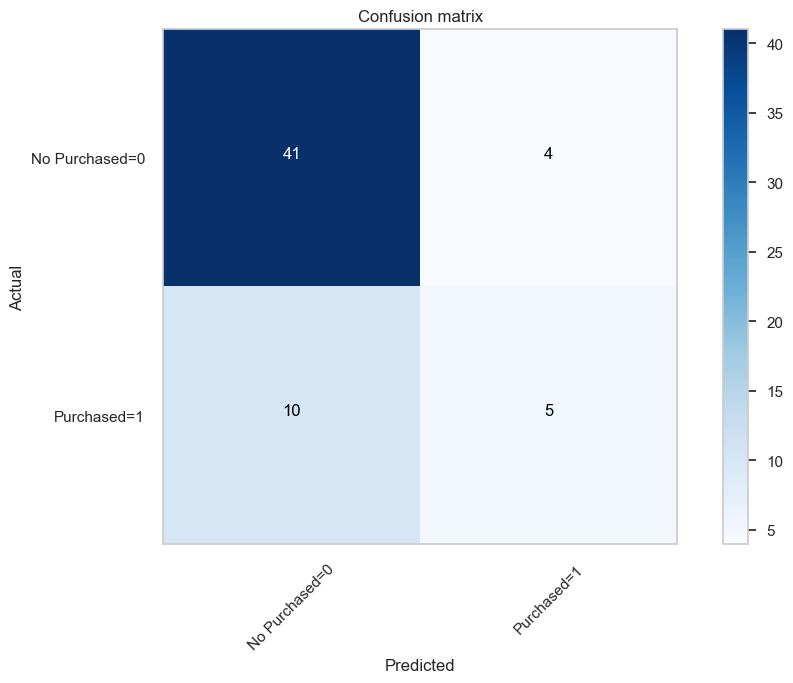

-------------------- Classification Report --------------------
                precision    recall  f1-score   support

No Purchased=0       0.80      0.91      0.85        45
   Purchased=1       0.56      0.33      0.42        15

      accuracy                           0.77        60
     macro avg       0.68      0.62      0.64        60
  weighted avg       0.74      0.77      0.74        60
 

Jaccard Score: 0.2631578947368421 



In [ ]:
# test test_size= 0.15
clf3, acc_test3, acc_train3 = modeling(x, y, 0.15, ['No Purchased=0', 'Purchased=1'])

-------------------- Shape --------------------
x_train: (360, 3)
y_train: (360, 1)
x_test: (40, 3)
y_test: (40, 1)


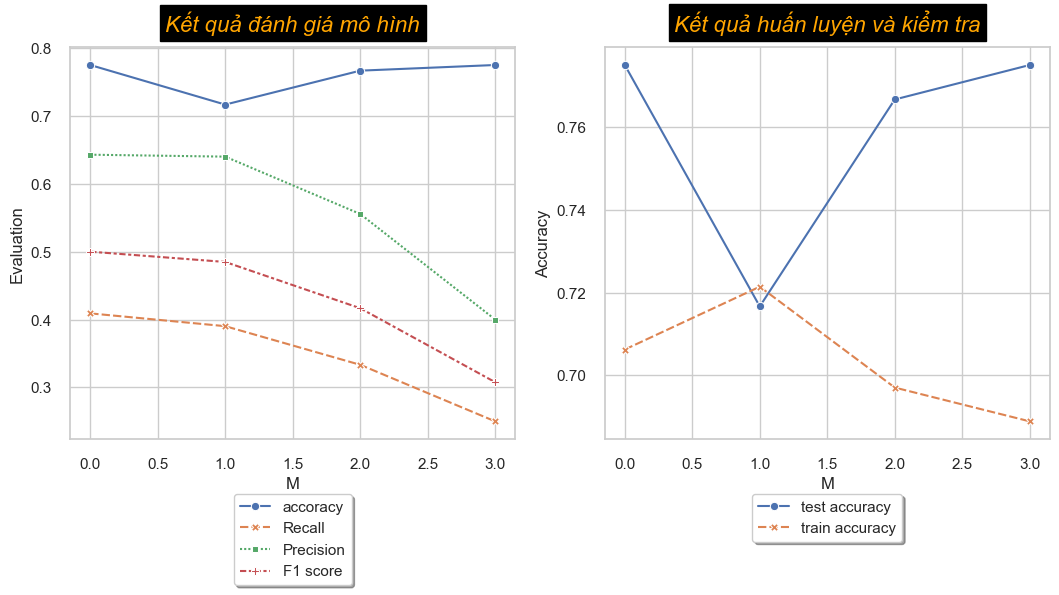

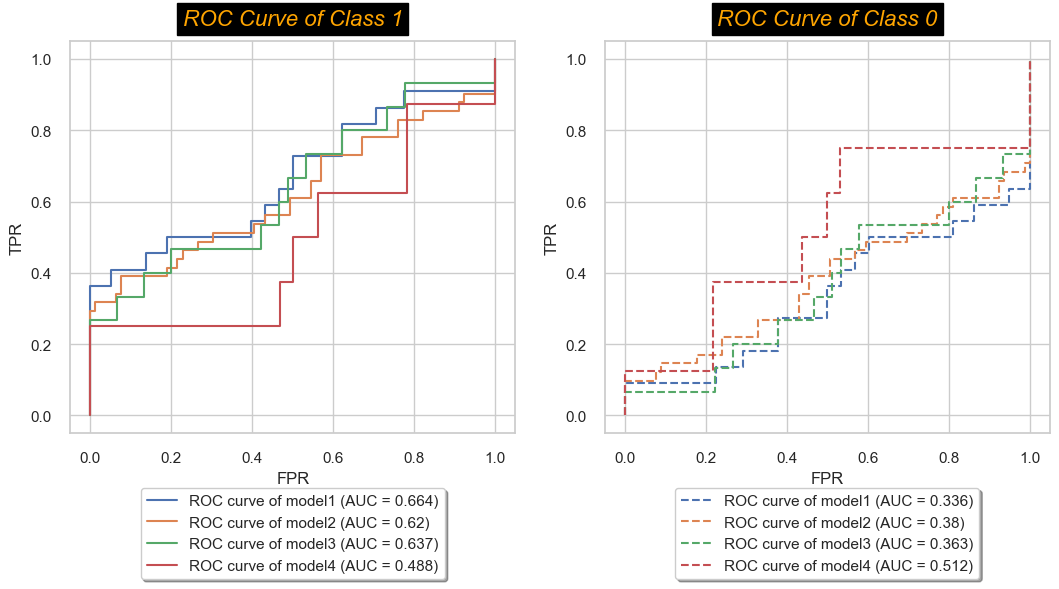

-------------------- Ma trận nhầm lẫn --------------------
[[29  3]
 [ 6  2]]


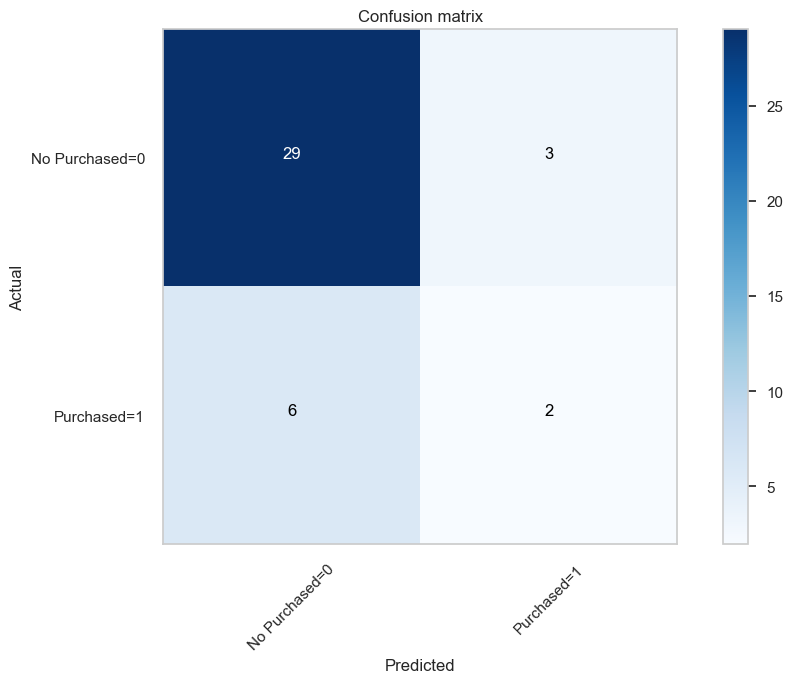

-------------------- Classification Report --------------------
                precision    recall  f1-score   support

No Purchased=0       0.83      0.91      0.87        32
   Purchased=1       0.40      0.25      0.31         8

      accuracy                           0.78        40
     macro avg       0.61      0.58      0.59        40
  weighted avg       0.74      0.78      0.75        40
 

Jaccard Score: 0.18181818181818182 



In [ ]:
# test test_size= 0.1
clf3, acc_test3, acc_train3 = modeling(x, y, 0.1, ['No Purchased=0', 'Purchased=1'])

test_size = 0,1 không cải thiện hiệu suất của mô hình. Vì vậy chúng ta xóa 3 kết quả cuối cùng vì chúng không cải thiện hiệu suất của mô hình.

In [ ]:
# delete 3 last results
del FPR1[1:]
del TPR1[1:]
del FPR0[1:]
del TPR0[1:]
del ACC_test[1:]
del ACC_train[1:]
del Recall[1:]
del Precision[1:]
del F1[1:]

Vì test_size=0.2 tốt hơn các tham số khác và việc chỉnh sửa siêu tham số này không làm thay đổi nhiều hiệu suất của mô hình. Bây giờ chúng ta cố gắng cải thiện mô hình bằng Xác thực chéo với hàm Performance_cross_val.

In [ ]:
Perform_cross_val(clf1, 10, x, y, scoring='accuracy')

-------------------- CV for k=10, scoring=accuracy --------------------
CV mean: 0.6399999999999999
CV results: [0.925 0.825 0.8   0.7   0.85  0.4   0.5   0.55  0.6   0.25 ]



Các nếp gấp 6 và 10 khác biệt nhiều so với mức trung bình so với các nếp gấp khác. Vì vậy, có thể loại bỏ chúng thì mô hình sẽ tốt hơn:

“Fold” (nghĩa là “nếp gấp” hay “phần”)

→ Trong ngữ cảnh Cross-Validation (kiểm định chéo), fold là một phần của tập dữ liệu sau khi chia nhỏ toàn bộ dữ liệu ra để đánh giá mô hình công bằng hơn.

In [ ]:
# trước tiên hãy tìm chỉ mục của datapoint ở phần 1 và 3 bằng cách sau:
find_fold_index(10, x)

fold 1: [0,39]
--------------------
fold 2: [40,79]
--------------------
fold 3: [80,119]
--------------------
fold 4: [120,159]
--------------------
fold 5: [160,199]
--------------------
fold 6: [200,239]
--------------------
fold 7: [240,279]
--------------------
fold 8: [280,319]
--------------------
fold 9: [320,359]
--------------------
fold 10: [360,399]
--------------------


Bây giờ chúng ta xóa chỉ mục [200-239] , [360-399]

In [ ]:
# delete above index from df2
df3 = df2.drop(df2.index[np.r_[200:239+1, 360:399+1]], axis=0)
print(f'df2:{df2.shape}')
print(f'df3:{df3.shape}')

df2:(400, 4)
df3:(320, 4)


In [ ]:
# define new x and y 
x2 = np.asanyarray(df3.drop('Purchased', axis=1))
y2 = df3.Purchased.values.reshape(-1,1)

-------------------- Shape --------------------
x_train: (256, 3)
y_train: (256, 1)
x_test: (64, 3)
y_test: (64, 1)


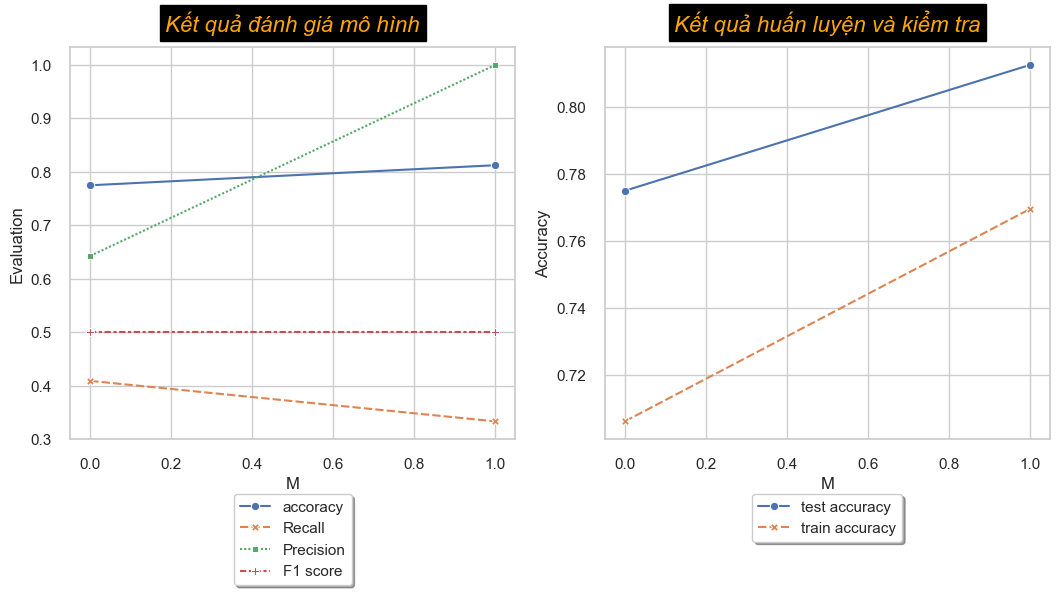

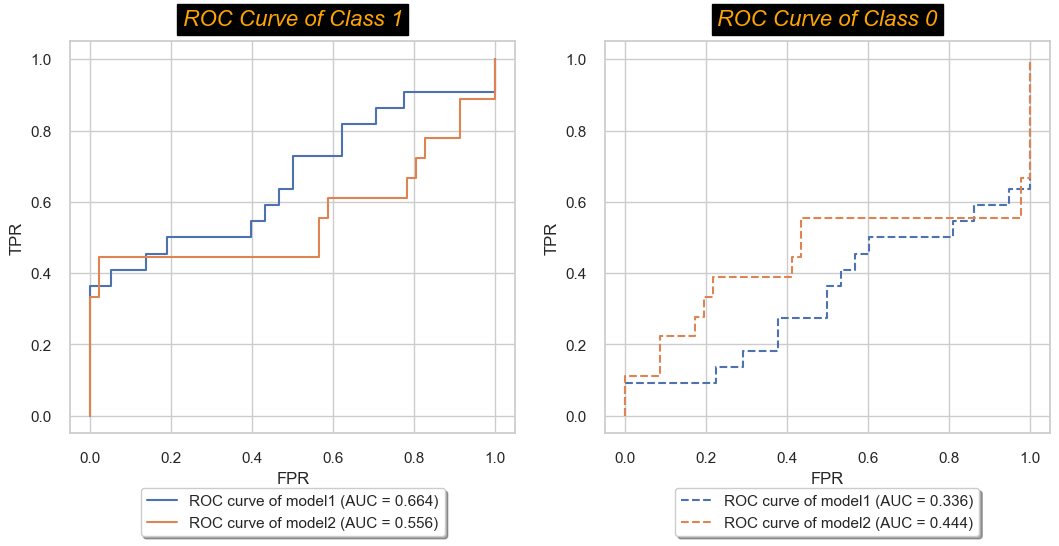

-------------------- Ma trận nhầm lẫn --------------------
[[46  0]
 [12  6]]


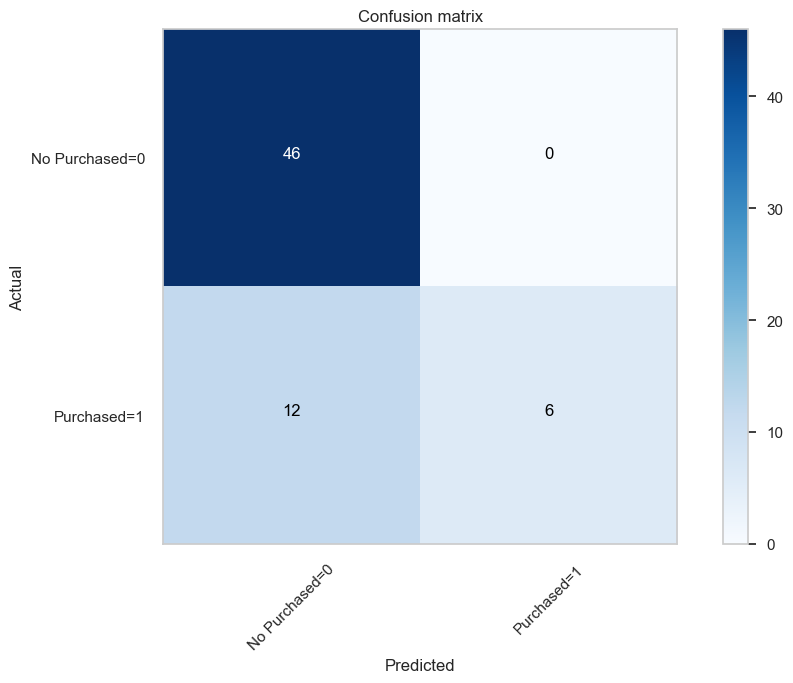

-------------------- Classification Report --------------------
                precision    recall  f1-score   support

No Purchased=0       0.79      1.00      0.88        46
   Purchased=1       1.00      0.33      0.50        18

      accuracy                           0.81        64
     macro avg       0.90      0.67      0.69        64
  weighted avg       0.85      0.81      0.78        64
 

Jaccard Score: 0.3333333333333333 



In [ ]:
clf2, acc_test2, acc_train2 = modeling(x2, y2, 0.2, classes=['No Purchased=0', 'Purchased=1'])

Bây giờ hiệu suất của mô hình đã được cải thiện và đạt độ chính xác 0,81. Như thể hiện trong ma trận nhầm lẫn và báo cáo phân loại, do thiếu dữ liệu ở lớp 1 nên độ chính xác của lớp này thấp và 12 người quyết định mua hàng đã bị dự đoán sai là lớp 0. Tuy nhiên, độ chính xác đạt được là tốt.

### 7. Mô hình trực quan cuối cùng

In [ ]:
%matplotlib inline
x_train, x_test, y_train, y_test = train_test_split(x2, y2, test_size=0.2, random_state=0)
x_test = np.concatenate((x_test, y_test), axis=1)
x_test = pd.DataFrame(x_test, columns=['Gender', 'Age', 'EstimatedSalary', 'Purchased'])

fig = px.scatter_3d(
    data_frame= x_test,
    x=x_test.Age,
    y=x_test.EstimatedSalary,
    z=x_test.Purchased,
    color=clf2.predict(x_test.drop('Purchased', axis=1)).astype(str),
    color_discrete_sequence={0:'red', 1:'green'},
    template='ggplot2',
    opacity=0.6,
    height=700,
    title=f'Visualization Performance of clf2 in Predicting')

pio.show(fig)

In [ ]:
clf2.predict(x_test.drop('Purchased', axis=1))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
      dtype=int64)

Trong hình vẽ ở trên, có thể thấy rất rõ rằng ở dưới cùng của khối, nơi tất cả dữ liệu được dự đoán chính xác và tất cả đều có màu đỏ, nhưng ở phía trên cùng của khối, nơi tất cả các vòng tròn phải có màu xanh lá cây, cũng có các vòng tròn màu đỏ, điều này cho thấy dự đoán sai.